<a href="https://colab.research.google.com/github/jofmorenore/Spatial_Clustering/blob/main/Spatial_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Grubesic, T, R. Wei and A. Murray (2014). Spatial clustering overview and comparison: accuracy, sensitivity and computational expense. Annals, Association of American Geographers 104, 1134-1156.](https://doi-org.ezproxy.unal.edu.co/10.1080/00045608.2014.958389)


# Configuración del entorno R en colab

In [ ]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
getwd()

[1] "/content"


In [5]:
%%R
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.2.3


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [Tipos de datos espaciales](http://user.math.uzh.ch/furrer/download/useR/20210707Furrer.pdf)

<p><img height="767" src="https://github.com/jofmorenore/Spatial_Clustering/raw/main/images/spatial_statistics.png" width="1057"/>

# [Datos de asaltos en Cincinnati](https://github.com/spatialanalysis/geodaData/blob/master/R/cincinnati.R)

In [15]:
%%R
library(dplyr)
library(ggplot2)

In [ ]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
library(sf)

In [7]:
%%R
load('/content/drive/MyDrive/cincinnati.rda')

In [10]:
%%R
str(cincinnati, max.level = 1)

Classes ‘sf’ and 'data.frame':	457 obs. of  73 variables:
 $ ID        : num  726907 695744 695762 695780 695798 ...
 $ AREA      : num  0.09 0.01 0.01 0.01 0.02 0.01 0 0 0 0.01 ...
 $ BLOCK     : chr  "390610042002001" "390610022004003" "390610033002017" "390610022004002" ...
 $ BG        : chr  "390610042002" "390610022004" "390610033002" "390610022004" ...
 $ TRACT     : chr  "39061004200" "39061002200" "39061003300" "39061002200" ...
 $ COUNTY    : chr  "39061" "39061" "39061" "39061" ...
 $ MSA       : chr  "1640" "1640" "1640" "1640" ...
 $ POPULATION: num  479 85 29 117 96 45 81 32 41 89 ...
 $ MALE      : num  221 39 18 59 51 30 39 21 27 33 ...
 $ FEMALE    : num  258 46 11 58 45 15 42 11 14 56 ...
 $ AGE_0_5   : num  6 5 0 9 1 0 3 1 0 5 ...
 $ AGE_5_9   : num  6 4 0 10 2 3 5 0 0 2 ...
 $ AGE_10_14 : num  3 8 0 11 2 1 9 0 0 7 ...
 $ AGE_15_19 : num  9 12 0 17 5 2 14 2 7 12 ...
 $ AGE_20_24 : num  32 6 13 12 28 14 29 19 11 26 ...
 $ AGE_25_34 : num  60 13 6 19 44 11 8 4 9 12 ...

In [13]:
%%R
n_blocks = n_distinct(cincinnati$ID)
n_assaults = sum(cincinnati$ASSAULT)
n_population = sum(cincinnati$POPULATION)
assault_rate = round((n_assaults/n_population)*100000)

cat("There are",n_blocks,"census blocks in the study area and the total number of observed assaults was",
    n_assaults,"for the time period examined. \nIn early 2008, the study area had a population of approximately",
    n_population,"over 148.7 km 2 (10.6 percent and 6.3 percent of the city, respectively). \nThe assault rate of this region is",
    assault_rate, "per 100,000 people, nearly 1.6 times the rate of the city with a relative risk of assault ranging from 0 to 45.2")


There are 457 census blocks in the study area and the total number of observed assaults was 462 for the time period examined. 
In early 2008, the study area had a population of approximately 38711 over 148.7 km 2 (10.6 percent and 6.3 percent of the city, respectively). 
The assault rate of this region is 1193 per 100,000 people, nearly 1.6 times the rate of the city with a relative risk of assault ranging from 0 to 45.2

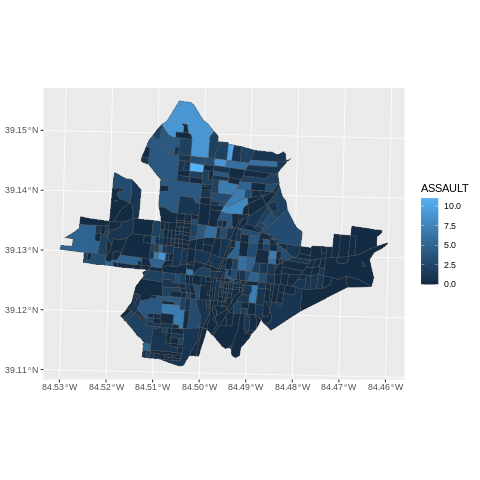

In [18]:
%%R
ggplot() + 
  geom_sf(data = cincinnati, aes(fill = `ASSAULT`))